<a href="https://colab.research.google.com/github/cultures/test/blob/master/5_Spatial_Joins_Census_Tracts_and_Tornado_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Joins: Census Tracts and Tornado Data
*By Caleb Robinson and Aaron Ferber*

## Overview

Goal: This jupyter notebook is designed to walk us through handling spatial data and doing things like spatial joins with spatial objects like points and polygons.

In this notebook we will learn about how data can be represented spatially, and standard techniques and formats for storing spatial data.

We then learn how to handle joining spatial data and doing lookups of finding which polygon a point lies in or which polygons overlap with other polygons.

The data we will use is historical tornado data from https://geodata.tufts.edu/

The census tract shapes are from the 2018 Tiger census data (https://www2.census.gov/geo/tiger/TIGER2018/TRACT/)

Census demographic data is from social explorer (https://www.socialexplorer.com/)

## Setting up the environment

### Download Data
Let's download the census data into the colab notebook environment using wget. We then extract the downloaded dataset. As you can see from the result of the unzip there are multiple files in this archive. Many of the files share the same name but have different extensions such as cpg, dbf, prj, shp, and shx. 

This is because this archive specifies a **shapefile** (https://en.wikipedia.org/wiki/Shapefile) which is essentially a standard format describing things like points, lines, and polygons, as well as some corresponding features of those spatial objects.

You can think of a shapefile as an Excel/CSV file where each _row_ of data also contains some shape (e.g. a point, a line, or a polygon) defined on the surface of the Earth. This gives a physical location, or area, to go along with the row of data!


Shapefiles have many uses of storing spatial data such as coordinates of elephant sightings, roads, or regions specifying wildfire regions. Below write out some ideas of what else a shapefile could help describe.

Shapefiles can be used for:
- example
- of
- uses

In [0]:
# Download Census tract shapes for 2018
!wget -Nq https://www2.census.gov/geo/tiger/TIGER2018/TRACT/tl_2018_01_tract.zip
!unzip -o tl_2018_01_tract.zip

Archive:  tl_2018_01_tract.zip
 extracting: tl_2018_01_tract.cpg    
  inflating: tl_2018_01_tract.dbf    
  inflating: tl_2018_01_tract.prj    
  inflating: tl_2018_01_tract.shp    
  inflating: tl_2018_01_tract.shp.ea.iso.xml  
  inflating: tl_2018_01_tract.shp.iso.xml  
  inflating: tl_2018_01_tract.shx    


In [0]:
# Download Tornado Data
!wget -Nq -O tornadoes.zip https://www.dropbox.com/s/wad1tylkr9m6iwb/Tornados%20United%20States%201950-2008.zip
!unzip -o tornadoes.zip

Archive:  tornadoes.zip
  inflating: GISPORTAL_GISOWNER01_USTORNADOS5008.cst  
  inflating: GISPORTAL_GISOWNER01_USTORNADOS5008.shp  
  inflating: GISPORTAL_GISOWNER01_USTORNADOS5008.prj  
  inflating: GISPORTAL_GISOWNER01_USTORNADOS5008.dbf  
  inflating: GISPORTAL_GISOWNER01_USTORNADOS5008.shx  
  inflating: wfsrequest.txt          
  inflating: GISPORTAL_GISOWNER01_USTORNADOS5008.shp.xml  


In [0]:
!wget -Nq "https://www.dropbox.com/s/jskc06dbocpa2fw/R12051374_SL140.csv"

### R-Trees
In order to easily handle the shapefiles and joining the data we will use a python implementation of the R-Tree datastructure (https://en.wikipedia.org/wiki/R-tree). Overall, this datastructure is useful for indexing complex spatial data like polygons  and has some other nice properties for computing things in spatial datasets quickly.

### Installing python packages
Here we install an rtree python package

In [0]:
!apt-get install python3-rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


We also install two other packages that are useful for handling spatial data

fiona (https://github.com/Toblerity/Fiona) is useful for reading and writing shapefile data which can be kind of messy to deal with on your own. It also "integrates readily with other Python GIS packages such as pyproj, Rtree, and Shapely" - from their readme.

shapely (https://github.com/Toblerity/Shapely) is useful for transforming, representing, and handling geometric shapes like points, polygons, etc. 

In [0]:
!pip install fiona shapely

### Taking a look at what we have
It's always good to take a look at what you have downloaded just to make sure. Of course, on your local system you may want to keep these files in a reasonably structured manner like putting things into a data directory or keeping track of tornadoes etc. Overall, you will want to keep track of where you got the data (so you can easily write it up later) and descriptions of what the files represent.

Here we can see that we have downloaded
- Tornado data shapefiles (GISPORTAL_GISOWNER01_USTORNADOS5008.*)
- Census tract shapefiles (t1_2018_01_tract.*)
- Census tract information (R12051374_SL140.csv)
- Tornado data (tornadoes)

Below we list out all (a) the files in long format (l as in Lima) with human readable file sizes (h). (http://man.openbsd.org/ls)

In [0]:
!ls -lah

total 99M
drwxr-xr-x 1 root root 4.0K Mar  2 00:51 .
drwxr-xr-x 1 root root 4.0K Mar  1 18:51 ..
drwxr-xr-x 1 root root 4.0K Feb 26 17:33 .config
-rw-r--r-- 1 root root   10 Mar  1 04:18 GISPORTAL_GISOWNER01_USTORNADOS5008.cst
-rw-r--r-- 1 root root  68M Mar  1 04:18 GISPORTAL_GISOWNER01_USTORNADOS5008.dbf
-rw-r--r-- 1 root root  379 Mar  1 04:18 GISPORTAL_GISOWNER01_USTORNADOS5008.prj
-rw-r--r-- 1 root root 1.4M Mar  1 04:18 GISPORTAL_GISOWNER01_USTORNADOS5008.shp
-rw-r--r-- 1 root root  28K Mar  1 04:18 GISPORTAL_GISOWNER01_USTORNADOS5008.shp.xml
-rw-r--r-- 1 root root 407K Mar  1 04:18 GISPORTAL_GISOWNER01_USTORNADOS5008.shx
-rw-r--r-- 1 root root 425K Mar  2 00:51 R12051374_SL140.csv
-rw-r--r-- 1 root root  635 Mar  1 19:02 R12051374_SL140.csvt
drwxr-xr-x 1 root root 4.0K Feb 26 17:33 sample_data
-rwxrwxr-x 1 root root    5 Sep  8 08:29 tl_2018_01_tract.cpg
-rwxrwxr-x 1 root root 124K Sep  8 08:29 tl_2018_01_tract.dbf
-rwxrwxr-x 1 root root  165 Sep  8 08:29 tl_2018_01_tract.prj
-r

## Import packages
Here let's import the spatial data packages we will need

In [0]:
%matplotlib inline
import sys, os, time

import numpy as np

import matplotlib.pyplot as plt

import fiona
import shapely
import shapely.geometry
import rtree

## Shapefiles and Fiona

Let's take a look at how to read a shapefile with fiona.

Below we open census tract data. the result of fiona.open is a file-like object. Here we can treat f as an iterable over dictionaries representing shape entries. 

Let's take a look at the first item to get an idea of what kinds of shapes we are getting.

In [0]:
# open shapefile with fiona
with fiona.open("tl_2018_01_tract.shp", "r") as f:
  # get first item in shape iterator
  example_data = next(iter(f))
print("fiona parsed us an object of type:", type(example_data))

fiona parsed us an object of type: <class 'dict'>


Here we can see that the dictionary has several keys, the type, id, properties, and geometry of the shape.

In [0]:
print("Keys specifying shape info", example_data.keys())

Keys specifying shape info dict_keys(['type', 'id', 'properties', 'geometry'])


Here we can just look at the keys without the geometry.

- id: '0', this just represents an index and is not the number of the census tract itself, we can't rely on this to crossreference with other data using census tract names.
- properties. This specifies details of the census tract such as the state ID (01), the county, a name, the amount of land, water, etc. This can usually be any kind of dictionary and here census tract data contains info specifying the precise name (GEOID) as well as other aspects of interest. 
- type: 'feature', This indicates that the object fiona pulled out of the shapefile is just some sort of feature, again this can be disregarded

Overall, for this data the main components of interest are the **geometry** and the **properties** keys. These essentially specify the shape itself as well as some properties the creator decided to associate with each shape.

In [0]:
{k:v for k,v in example_data.items() if k != "geometry"}

{'id': '0',
 'properties': OrderedDict([('STATEFP', '01'),
              ('COUNTYFP', '087'),
              ('TRACTCE', '232100'),
              ('GEOID', '01087232100'),
              ('NAME', '2321'),
              ('NAMELSAD', 'Census Tract 2321'),
              ('MTFCC', 'G5020'),
              ('FUNCSTAT', 'S'),
              ('ALAND', 5357837),
              ('AWATER', 58722),
              ('INTPTLAT', '+32.4037650'),
              ('INTPTLON', '-085.7172586')]),
 'type': 'Feature'}

Looking at the **geometry** field, we see again that it's a dictionary containing a **type** and **coordinates**. The type isn't too helpful for us since we already know that the census tracts are all polygons; however, if someone is storing points in there as well, this can help us determine what the coordinates specify.

In [0]:
print("keys:", example_data["geometry"].keys())
print("coordinates:", example_data["geometry"]["coordinates"])
print("type:", example_data["geometry"]["type"])

keys: dict_keys(['type', 'coordinates'])
coordinates: [[(-85.73401, 32.408105), (-85.733896, 32.408167999999996), (-85.733381, 32.408505999999996), (-85.733037, 32.408755), (-85.732877, 32.408817), (-85.732738, 32.408842), (-85.732579, 32.40885), (-85.732418, 32.408910999999996), (-85.73225699999999, 32.409027), (-85.732053, 32.409196), (-85.73191299999999, 32.409321), (-85.731816, 32.409436), (-85.73173, 32.409490999999996), (-85.731613, 32.409489), (-85.731539, 32.409433), (-85.731402, 32.40936), (-85.731201, 32.409287), (-85.730842, 32.409103), (-85.730671, 32.409127999999995), (-85.730575, 32.40918), (-85.730521, 32.409262), (-85.730446, 32.409306), (-85.730329, 32.409314), (-85.730212, 32.409259), (-85.730096, 32.409231), (-85.730074, 32.409292), (-85.730071, 32.409501), (-85.730015, 32.409708), (-85.72992599999999, 32.409931), (-85.729861, 32.410075), (-85.729838, 32.410184), (-85.72989, 32.410292999999996), (-85.730015, 32.410455999999996), (-85.730088, 32.410582999999995), (-85

The coordinates here are essentially a list of polygons (since it's possible the region is not contiguous). For this instance though, there is just one polygon and we can see that it is described by 585 points.

In [0]:
print("num polygons in entry:", len(example_data["geometry"]["coordinates"]))
print("num points describing polygon:", len(example_data["geometry"]["coordinates"][0]))
example_data["geometry"]["coordinates"]

num polygons in entry: 1
num points describing polygon: 585


[[(-85.73401, 32.408105),
  (-85.733896, 32.408167999999996),
  (-85.733381, 32.408505999999996),
  (-85.733037, 32.408755),
  (-85.732877, 32.408817),
  (-85.732738, 32.408842),
  (-85.732579, 32.40885),
  (-85.732418, 32.408910999999996),
  (-85.73225699999999, 32.409027),
  (-85.732053, 32.409196),
  (-85.73191299999999, 32.409321),
  (-85.731816, 32.409436),
  (-85.73173, 32.409490999999996),
  (-85.731613, 32.409489),
  (-85.731539, 32.409433),
  (-85.731402, 32.40936),
  (-85.731201, 32.409287),
  (-85.730842, 32.409103),
  (-85.730671, 32.409127999999995),
  (-85.730575, 32.40918),
  (-85.730521, 32.409262),
  (-85.730446, 32.409306),
  (-85.730329, 32.409314),
  (-85.730212, 32.409259),
  (-85.730096, 32.409231),
  (-85.730074, 32.409292),
  (-85.730071, 32.409501),
  (-85.730015, 32.409708),
  (-85.72992599999999, 32.409931),
  (-85.729861, 32.410075),
  (-85.729838, 32.410184),
  (-85.72989, 32.410292999999996),
  (-85.730015, 32.410455999999996),
  (-85.730088, 32.4105829999

### Handling geometry with shapely
We want to avoid having to handle all those 585 points, dealing with edge cases, unit conversions, etc ourselves. To avoid this, we can use shapely to automatically read in the geometry as a shape object with **shapely.geometry.shape**

shape has type: <class 'shapely.geometry.polygon.Polygon'>


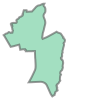

In [0]:
# parse geometry dict using shape
example_shape = shapely.geometry.shape(example_data["geometry"])
print("shape has type:", type(example_shape))
# colab notebooks print out the shapes nicely for us
example_shape

This polygon has some useful properties that may make things easier for us, and other libraries such as the bounding box, the points themselves, the convex hull, a centroid, and other things you may want that you can find in the documentation (https://shapely.readthedocs.io/en/latest/manual.html)

In [0]:
print("bounds:",example_shape.bounds)
print("centroid:",example_shape.centroid)
print("area:",example_shape.area) # note that area is in this unit system

bounds: (-85.73401, 32.380511999999996, -85.706389, 32.422278999999996)
centroid: POINT (-85.71790541143665 32.40284200130443)
area: 0.0005191935254999833


### Sanity checking the shapefile
Here we can ask fiona to give us some high-level info about our shapefile. We need to make sure that the coordinate system we are using is the same between all of our shapes/points/etc to ensure that we can query for things like distance. 

Below we get the info from the tl_2018_01_tract.shp which tells us the following useful info.
- properties: we investigated above what the properties were but we can take a look at the schema to know for ourselves, of course nothing beats looking at the raw data but this will help you easily identify things that might be of interest such as the GeoID, and the name among other things.
- geometry: this info also tells you that this shapefile is storing polygons, but other shapefiles may store something else
- crs: **coordinate reference system**(https://en.wikipedia.org/wiki/Spatial_reference_system), here we can see that EPSG:4269 (https://epsg.io/4269) is used for this shapefile. A wide variety of systems are used for different purposes, with some being offset by different amounts and other being in other units such as meters offset from some location.
- count: a friendly count of the number of objects we have in our polygon
- name: the name of the shapefile, this is not necessarily the name of the actual file
- bounds: bounding box for the shapefile, all of the polygons are contained within these points in this coordinate system.

In [0]:
!fio info --indent 2 tl_2018_01_tract.shp

{
  "driver": "ESRI Shapefile",
  "schema": {
    "properties": {
      "STATEFP": "str:2",
      "COUNTYFP": "str:3",
      "TRACTCE": "str:6",
      "GEOID": "str:11",
      "NAME": "str:7",
      "NAMELSAD": "str:20",
      "MTFCC": "str:5",
      "FUNCSTAT": "str:1",
      "ALAND": "int:14",
      "AWATER": "int:14",
      "INTPTLAT": "str:11",
      "INTPTLON": "str:12"
    },
    "geometry": "Polygon"
  },
  "crs": "EPSG:4269",
  "crs_wkt": "GEOGCS[\"NAD83\",DATUM[\"North_American_Datum_1983\",SPHEROID[\"GRS 1980\",6378137,298.257222101,AUTHORITY[\"EPSG\",\"7019\"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY[\"EPSG\",\"6269\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4269\"]]",
  "bounds": [
    -88.473227,
    30.144425,
    -84.888246,
    35.008027999999996
  ],
  "name": "tl_2018_01_tract",
  "count": 1181
}


Here you should take a look at the other shapefile we downloaded: GISPORTAL_GISOWNER01_USTORNADOS5008.shp and give some info about what data is contained there

In [0]:
# Your code here:


### Read + Parse Census with Fiona and Shapely
Here let's ask Fiona to read in all the shapes, and we can store the things we are interested in like the GEOID property and the geometry. There are numerous ways we could do this, but since we only need to keep track of the GEOID and the shape itself, let's just keep a tuple of (GEOID, shape object) pairs. If we wanted to, the read in shapes are just dictionaries so we could process the geometry and just add the shape itself as a new key, but for this tutorial we will keep it simple.

In [0]:
census_tracts = []

# open shapefile with fiona
with fiona.open("tl_2018_01_tract.shp","r") as f:
  
  # iterate over shapes
  for row in f:
    # convert geometry to shapely shape
    geom = shapely.geometry.shape(row["geometry"])
    
    # get GEOID property from shape
    geoid = row["properties"]["GEOID"]
    
    # append both geoid and shape to list of census tracts
    census_tracts.append((geoid, geom))

One nice thing about shapely shapes and colab notebooks is that it nicely displays the shape

last parsed shape, id: 01087231800


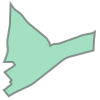

In [0]:
print("last parsed shape, id:", geoid)
geom

### Handle Tornado Data
for the tornado data we can simply get the locations, if we want we can also track other information we might be interested in such as intensity of the storm or storm duration. For now though, let's just look at where tornadoes are occurring.

In [0]:
tornado_points = []
# open tornado shapefile with fiona
with fiona.open("GISPORTAL_GISOWNER01_USTORNADOS5008.shp","r") as f:
  # iterate over shapes in shapefile (in this case they are points)
  for row in f:
    # convert geometry to shapely shape
    geom = shapely.geometry.shape(row["geometry"])
    # append shape to data
    tornado_points.append(geom)

point type: <class 'shapely.geometry.point.Point'>


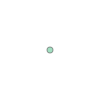

In [0]:
print("point type:", type(tornado_points[0]))
tornado_points[0]

Again, points have similar aspects of all shapes such as the xy location itself

In [0]:
tornado_points[0].bounds

(-88.19999999990006, 30.66999999960035, -88.19999999990006, 30.66999999960035)

In [0]:
tornado_points[0].xy

(array('d', [-88.19999999990006]), array('d', [30.66999999960035]))

In [0]:
# let's get all xy pairs
xs, ys = [], []
# iterate over points
for pt in tornado_points:
  # append x and y to lists
  xs.append(pt.x)
  ys.append(pt.y)

#### Visualize Tornado Data
We can now visualize where these tornado points are by just scattering the x and y coordinates. Setting the alpha (opacity) to be smaller means we can get a sense of the density of the points across the US.

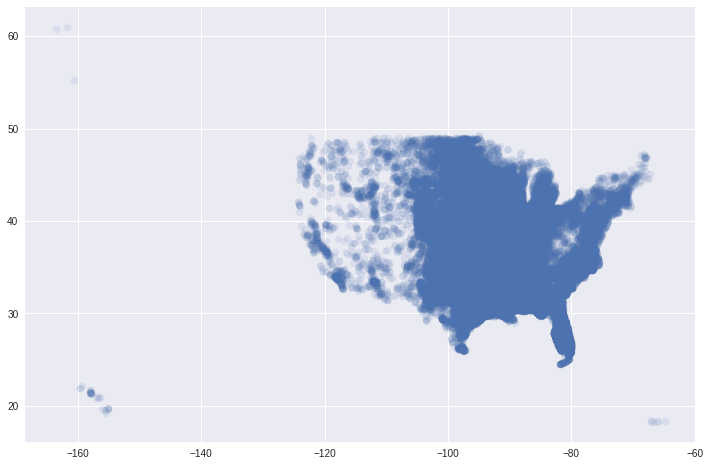

In [0]:
# visualize the points
plt.figure(figsize=(12,8))
plt.scatter(xs, ys, alpha=0.1)

## Spatial Indexing: RTrees
Here we will create a spatial index using the rtree package so that we can easily lookup which points lie in which polygons.

In [0]:
# initialize rtree spatial index
tract_index = rtree.index.Index()

# iterate over census tracts
for i, (geoid, tract) in enumerate(census_tracts):
  # add bounding box of census tract and store geoid along with it
  tract_index.insert(i, coordinates=tract.bounds, obj=geoid)
  
# we can now query this datastructure with a point and it will tell us which 
# polygon it lies in

We can query this index by using tract_index.intersection to get a list of the items we originally added which intersect with the shape we query with.

In [0]:
# given a point, we can lookup which shapes intersects it
shape_id_containing_point = next(tract_index.intersection(coordinates=[-88.2, 30.67]))

# we can now use this index to do as we please with the data
print("geoid and shape:",census_tracts[shape_id_containing_point])

geoid and shape: ('01097003703', <shapely.geometry.polygon.Polygon object at 0x7f5a61009320>)


## Counting the number of tornadoes per census tract

Let's use this to now count up how many tornadoes are in a given census tract.

How can we accomplish this with the spatial index?

In [0]:
# default dictionary (a dictionary with a default value if a key doesn't exist)
from collections import defaultdict

### Tornado County Lookup

In [0]:
# initialize default dict to store ints (counts of tornadoes)
num_tornadoes_per_tract = defaultdict(int)

# iterate over all tornado points
for tornado_pt in tornado_points:
  # get iterable (generator) of indices whose bounding boxes overlaps with tornado
  for overlapping_ind in tract_index.intersection(tornado_pt.bounds):
    # check if the polygon actually contains the point (somewhat expensive)
    # just because the rtree says there is an intersection in BOUNDING BOX 
    # doesn't mean the actual polygon contains the point
    # here we use the polygon contains function
    if census_tracts[overlapping_ind][1].contains(tornado_pt):
      # add 1 to tornado count of containing tract
      num_tornadoes_per_tract[census_tracts[overlapping_ind][0]] += 1

Let's look at some basic things, like which tract contains the most tornadoes

In [0]:
max_tornado_tract = max(num_tornadoes_per_tract, key=num_tornadoes_per_tract.get)
print("census tract with most tornadoes:", max_tornado_tract)
print("number of tornadoes in largest tract:", num_tornadoes_per_tract[max_tornado_tract])

census tract with most tornadoes: 01101005604
number of tornadoes in largest tract: 11


### Buffered tornadoes
However, in the real world tornadoes may effect regions larger than the point itself. We may want to have a buffered region around the tornado that essentially says it will effect an area surrounding it. We can now create a circle around the tornado points by adding a buffer of 0.05 to the tornadoes.

In [0]:
num_buffered_tornadoes_per_tract = defaultdict(int)

for tornado_pt in tornado_points:
  buffered_tornado = tornado_pt.buffer(0.05)
  # get iterable (generator) of indices whose bounding boxes overlaps with tornado
  for overlapping_ind in tract_index.intersection(buffered_tornado.bounds):
    # check if the polygon actually INTERSECTS the buffered tornado (somewhat expensive)
    if census_tracts[overlapping_ind][1].intersects(buffered_tornado):
      # add 1 to tornado count of INTERSECTS tract
      num_buffered_tornadoes_per_tract[census_tracts[overlapping_ind][0]] += 1

In [0]:
max_buffered_tornado_tract = max(num_buffered_tornadoes_per_tract, 
                                 key=num_buffered_tornadoes_per_tract.get)
print("census tract with most tornadoes:", max_buffered_tornado_tract)
print("number of tornadoes in largest tract:", num_buffered_tornadoes_per_tract[max_buffered_tornado_tract])


census tract with most tornadoes: 01003990000
number of tornadoes in largest tract: 33


## Loading Actual Census Data
We were previously working with the census tract shapes themselves, but now let's try to actual census data to try and see what types of counties are disproportionately affected by tornadoes

In [0]:
census_tract_data = {}
# open the census data for reading
with open("R12051374_SL140.csv", "r") as f: # awful filename
  # parse out header
  header=[p.strip('"') for p in f.readline().strip().split("\t")] # each cell has quotes around it
  f.readline()
  # iterate over remaining lines
  for line in f:
    # get value in each cell
    parts = [p.strip('"') for p in line.strip().split("\t")] # each cell has quotes around it
    assert len(header) == len(parts)
    # create dictionary tracking data
    line = dict(zip(header, parts))
    # add to file using FIPS name
    census_tract_data[line["FIPS"]] = line

Now that we have loaded the data we can take a look at what columns there are

In [0]:
header

['FIPS',
 'Geographic Identifier',
 'Name of Area',
 'Qualifying Name',
 'State/U.S.-Abbreviation (USPS)',
 'Summary Level',
 'Geographic Component',
 'File Identification',
 'Logical Record Number',
 'US',
 'Region',
 'Division',
 'State (Census Code)',
 'State (FIPS)',
 'County',
 'County Subdivision (FIPS)',
 'Place (FIPS Code)',
 'Place (State FIPS + Place FIPS)',
 'Census Tract',
 'Block Group',
 'Consolidated City',
 'American Indian Area/Alaska Native Area/Hawaiian Home Land (Census)',
 'American Indian Area/Alaska Native Area/Hawaiian Home Land (FIPS)',
 'American Indian Trust Land/Hawaiian Home Land Indicator',
 'American Indian Tribal Subdivision (Census)',
 'American Indian Tribal Subdivision (FIPS)',
 'Alaska Native Regional Corporation (FIPS)',
 'Metropolitan and Micropolitan Statistical Area',
 'Combined Statistical Area',
 'Metropolitan Division',
 'Metropolitan Area Central City',
 'Metropolitan/Micropolitan Indicator Flag',
 'New England City and Town Combined Statisti

Let's also make sure that the census tracts align with the shapes we have. We will be in trouble if we have data with no associated shapes or shapes with data missing. We can do this by taking set differences and checking that they are empty.

In [0]:
# check out the keys
census_tract_ids = map(lambda x:x[0], census_tracts)
census_tract_data.keys()

dict_keys(['01001020100', '01001020200', '01001020300', '01001020400', '01001020500', '01001020600', '01001020700', '01001020801', '01001020802', '01001020900', '01001021000', '01001021100', '01003010100', '01003010200', '01003010300', '01003010400', '01003010500', '01003010600', '01003010701', '01003010703', '01003010704', '01003010705', '01003010800', '01003010903', '01003010904', '01003010905', '01003010906', '01003011000', '01003011101', '01003011102', '01003011201', '01003011202', '01003011300', '01003011401', '01003011403', '01003011405', '01003011406', '01003011407', '01003011408', '01003011501', '01003011502', '01003011601', '01003011602', '01003990000', '01005950100', '01005950200', '01005950300', '01005950400', '01005950500', '01005950600', '01005950700', '01005950800', '01005950900', '01007010001', '01007010002', '01007010003', '01007010004', '01009050101', '01009050102', '01009050200', '01009050300', '01009050400', '01009050500', '01009050601', '01009050602', '01009050700',

In [0]:
# check if we have any shapes with missing data
set(census_tract_data.keys()) - set(census_tract_ids)

set()

In [0]:
# check if we have any census data with missing shapes
set(census_tract_ids) - set(census_tract_data.keys())

set()

In [0]:
# sanity check on the number of tracts we have data on
len(census_tract_data.keys())

1181

In [0]:
# sanity check on the number of tracts we have shapes for
len(census_tracts)

1181

In [0]:
# rtree lets us easily find the n tracts that are closest to a query point too, pretty sure this will be with euclidean distance
list(tract_index.nearest(tornado_points[0].bounds, 5)) # "easy game, easy life" - Caleb

[312, 335, 313, 718, 332]

## Machine Learning on the Tornado Data
Let's try to predict tornado counts based on population makeup. This may help us get a sense of how tornadoes may disproportionately affect some groups, or how areas with certain dynamics form. Mostly though, it's a good excercise on what we can do with this data.

In [0]:
# initialize dataset
x_train = []
y_train = []

# iterate over census tracts with tornado counts
for geoid, num_tornadoes in num_tornadoes_per_tract.items():
  
  num_young = float(census_tract_data[geoid]["Total Population: 5 to 9 Years"])
  num_old = float(census_tract_data[geoid]["Total Population: 85 Years and Over"])
  
  x_train.append([num_young, num_old])
  y_train.append(num_tornadoes)
x_train = np.array(x_train)
y_train = np.array(y_train)

### Visualize Data
Since we are working with two Caleb-selected features, let's just do a scatter plot of the target with respect to each feature

Text(0, 0.5, 'num tornadoes')

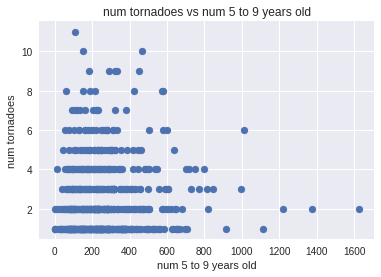

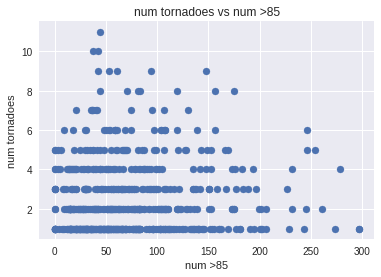

In [0]:
plt.figure()
plt.scatter(x_train[:, 0], y_train)
plt.title("num tornadoes vs num 5 to 9 years old")
plt.xlabel("num 5 to 9 years old")
plt.ylabel("num tornadoes")

plt.figure()
plt.scatter(x_train[:, 1], y_train)
plt.title("num tornadoes vs num >85")
plt.xlabel("num >85")
plt.ylabel("num tornadoes")

It looks like the youth and elderly tend to not co-occur with tornadoes. Heavy tornado locations seem to not be super inhabited by youth and elderly.

### Run a machine learning model

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

Here the model isn't able to explain too much of the tornado variability as a function of the number of elderly and the number of youth.

In [0]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_train)
print("linear regression r^2:",metrics.r2_score(y_train, y_pred))

linear regression r^2: 0.00042959871381909043


In [0]:
import xgboost as xgb

Here we can see that XGB is able to find some signal (not really sure that we aren't overfitting though, we need to do cross-validation for that)

In [0]:
model = xgb.XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_train)
print("linear regression r^2:",metrics.r2_score(y_train, y_pred))

linear regression r^2: 0.31231216470801026


# Links
- Shapefiles: https://en.wikipedia.org/wiki/Shapefile
- Coordinate Reference System (CRS): https://en.wikipedia.org/wiki/Spatial_reference_system)
 - EPSG-4269: https://epsg.io/4269
- RTrees: https://en.wikipedia.org/wiki/R-tree
- Fiona: https://github.com/Toblerity/Fiona
- Shapely: https://github.com/Toblerity/Shapely
 - Manual: https://shapely.readthedocs.io/en/latest/manual.html
- GeoPandas: https://github.com/geopandas/geopandas

# Spatial Joins The Pandas Way: "Easy Game Easy Life - Caleb" ~ Aaron

We can do a very similar thing pretty quickly using geopandas (https://github.com/geopandas/geopandas) which essentially integrates pandas (data handling like SQL), Fiona, Rtree, Shapely and many other shape-related things.

In [0]:
!pip install geopandas

In [0]:
# let's also install descartes, a way to easily visualize maps used by geopandas
!pip install descartes

In [0]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# read the census shapefile
census_gdf = geopandas.read_file("tl_2018_01_tract.shp")

# read the tornado shapefile
tornado_gdf = geopandas.read_file("GISPORTAL_GISOWNER01_USTORNADOS5008.shp")

# read census data
# we need to handle some things like it being delimited by tabs instead of spaces
# also, there are two header rows
# lastly, we need tom parse the geoid as a string as it has leading zeros
# also skip the second row since it just has formal names for the features
census_df = pd.read_csv("R12051374_SL140.csv", skiprows=[1], delimiter="\t", dtype={'FIPS': str})

In [0]:
print("census shape num:", len(census_gdf))
print("tornado point num:", len(tornado_gdf))
print("census info num:", len(census_df))

census shape num: 1181
tornado point num: 52007
census info num: 1181


## Visualize Tornado Data
We can visualize the data just by calling plot

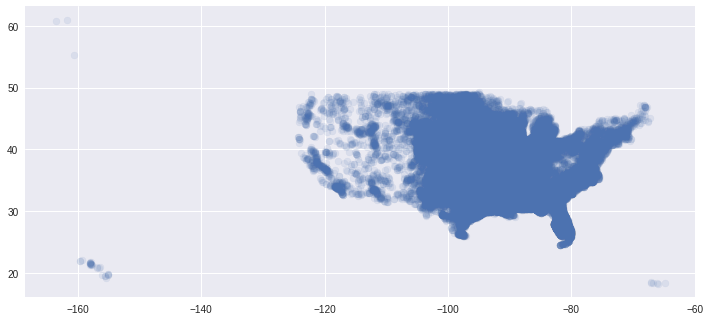

In [0]:
tornado_gdf.plot(figsize=(12,8), alpha=0.1)

## Visualize Census Tracts

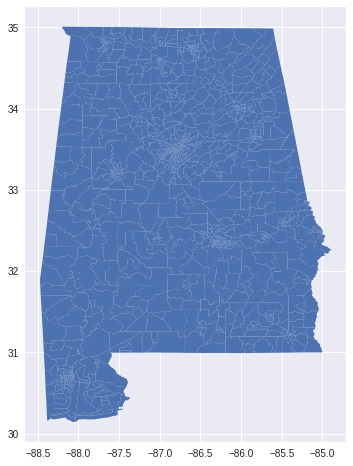

In [0]:
census_gdf.plot(figsize=(12,8))

## Merge Census features and shapefile
This is a standard merger, what we do is basically join the census shape data with the census demographic data on the geoid (called FIPS in the demographic data). Inner join just means take rows with geoid in both dataframes

In [0]:
merged_census_df = census_gdf.merge(right=census_df, how="inner", left_on="GEOID", right_on="FIPS")

In [0]:
print("num census after merge:", len(merged_census_df))

num census after merge: 1181


## Visualize Census Features in tracts

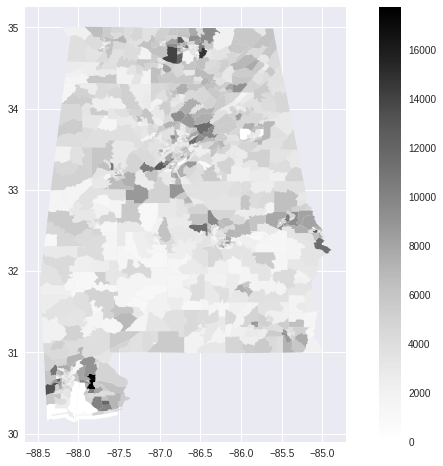

In [0]:
merged_census_df.plot(figsize=(12,8), column="Total Population:", legend=True)

## Spatial Merge
Now let's merge this with the tornado data getting tornado counts per census block

In [0]:
# lookup the census block that the tornadoes lie in.
# Only keep tornadoes which appear in some census block we have data for (right)
spatial_merged_gdf = geopandas.sjoin(tornado_gdf, merged_census_df, how="right")

In [0]:
# Some census data rows may not have any tornadoes.
# We can check this by determining whether the tornado index is null
# indicating no tornado was found for the region
print("num tornadoes in region:", spatial_merged_gdf["index_left"].count())

num tornadoes in region: 1578


In [0]:
# we can now group the merged data by the GEOID of the census data
tornado_counts = spatial_merged_gdf.groupby("GEOID")[["index_left"]].count()
# remove index, just create column
tornado_counts = tornado_counts.reset_index(level=0)
# rename index_left column to something reasonable
tornado_counts = tornado_counts.rename(columns={"index_left":"num_tornadoes"})

In [0]:
tornado_counts.head()

,GEOID,num_tornadoes
0,01001020100,1
1,01001020200,0
2,01001020300,0
3,01001020400,0
4,01001020500,0


In [0]:
# now we can merge the tornado counts back into our dataframe
census_with_tornado_counts_df = merged_census_df.merge(tornado_counts, how="left", on="GEOID")

## Visualize Tornado Counts

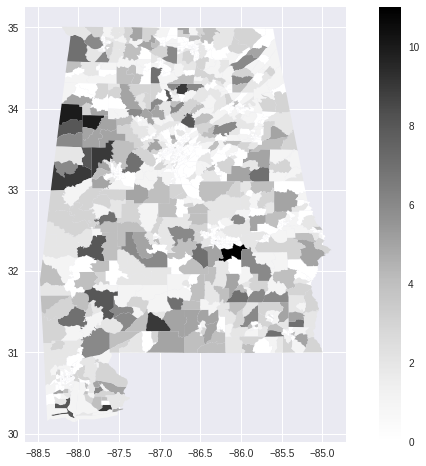

In [0]:
census_with_tornado_counts_df.plot(figsize=(12,8), column="num_tornadoes", legend=True)

Text(0.5, 0, 'number of census tracts with specified tornado count')

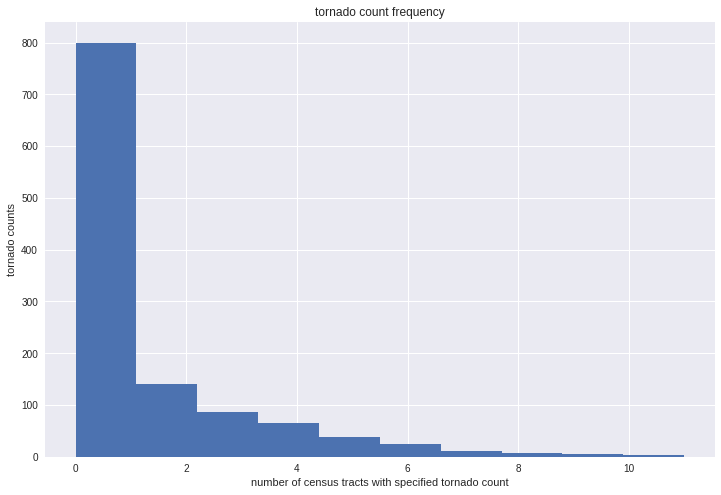

In [0]:
census_with_tornado_counts_df["num_tornadoes"].hist(figsize=(12,8))
plt.title("tornado count frequency")
plt.ylabel("tornado counts")
plt.xlabel("number of census tracts with specified tornado count")

## Buffer Tornadoes

In [0]:
buffer_amount = 0.05
buffered_tornado_gdf = tornado_gdf
buffered_tornado_gdf["geometry"] = tornado_gdf.buffer(buffer_amount)
buffered_spatial_merged_gdf = geopandas.sjoin(buffered_tornado_gdf, merged_census_df, how="right")
print("num tornadoes in region:", spatial_merged_gdf["index_left"].count())

buffered_tornado_counts = buffered_spatial_merged_gdf.groupby("GEOID")[["index_left"]].count()
# remove index, just create column
buffered_tornado_counts = buffered_tornado_counts.reset_index(level=0)
# rename index_left column to something reasonable
buffered_tornado_counts = buffered_tornado_counts.rename(columns={"index_left":"num_buffered_tornadoes"})

census_with_buffered_tornado_counts_df = merged_census_df.merge(buffered_tornado_counts, how="left", on="GEOID")

num tornadoes in region: 1578


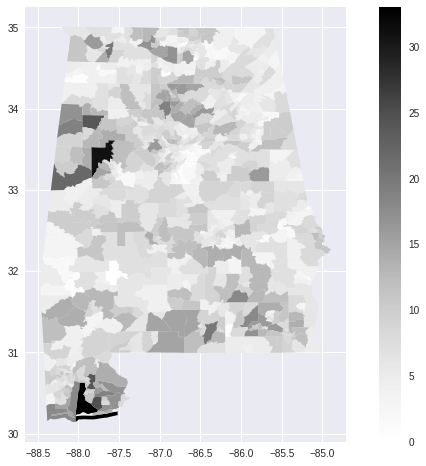

In [0]:
census_with_buffered_tornado_counts_df.plot(column="num_buffered_tornadoes", figsize=(12,8), legend=True)

In [0]:
# get the row with most number of buffered tornadoes
max_row = census_with_buffered_tornado_counts_df.iloc[np.argmax(census_with_buffered_tornado_counts_df["num_buffered_tornadoes"])]
max_row[["GEOID", "num_buffered_tornadoes"]]
# as we can see it matches the previous solution!

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


GEOID                     01003990000
num_buffered_tornadoes             33
Name: 494, dtype: object

We can now treat the tornado counts just like any other data

Text(0.5, 0, 'number of census tracts with specified tornado count')

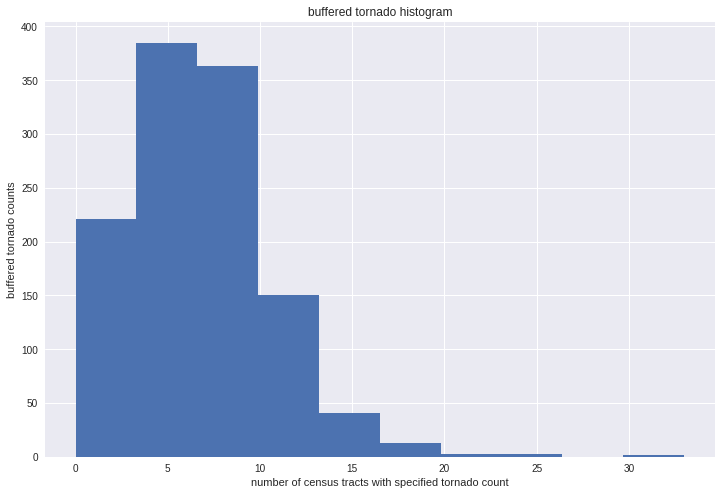

In [0]:
census_with_buffered_tornado_counts_df["num_buffered_tornadoes"].hist(figsize=(12,8))
plt.title("buffered tornado histogram")
plt.ylabel("buffered tornado counts")
plt.xlabel("number of census tracts with specified tornado count")